In [62]:
from backtesting import Backtest, Strategy
import talib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

np.random.seed(42)

df = pd.read_csv("../Data/^GSPC.csv")
df = df[df["Price"] != "Ticker"]
df = df[df["Price"] != "Date"]
df[['Close','High', 'Low', 'Open', 'Volume']]= df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)
df['Price'] = pd.to_datetime(df['Price'])
df.set_index('Price', inplace=True)
df.index.name = None

def add_features(data):
    """Use existing features and add additional ones for ML model"""
    df = data.copy()
    
    # Use the existing indicators (MA5, MA10, MA20, Volatility, Momentum)
    # and create additional features from them
    
    # Normalized price distances from MAs
    df['X_MA5'] = (df.Close - df.MA5) / df.Close
    df['X_MA10'] = (df.Close - df.MA10) / df.Close
    df['X_MA20'] = (df.Close - df.MA20) / df.Close
    
    # MA crossovers
    df['X_MA5_10'] = (df.MA5 - df.MA10) / df.Close
    df['X_MA10_20'] = (df.MA10 - df.MA20) / df.Close
    
    # Use existing Volatility and Momentum
    df['X_Volatility'] = df.Volatility
    df['X_Momentum'] = df.Momentum
    
    # Relative return features
    df['X_Return'] = df.Return
    df['X_Return_5'] = df.Return.rolling(5).sum()
    
    # Volume features
    df['X_VOL_CHG'] = df.Volume.pct_change(5)
    
    # Convert to our desired format if it's not already binary
    df['Target_orig'] = df.Target
    df['Target'] = np.where(df.Return.shift(-1) > 0.005, 1,    # Long if >0.5% up
                    np.where(df.Return.shift(-1) < -0.005, -1,  # Short if >0.5% down
                    0))                                         # No position if in between
    
    return df.dropna()

def get_X(data):
    """Return feature matrix X"""
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values

def get_y(data):
    """Return target variable y"""
    y = data.Target.values
    return np.where(y == -1, 0, np.where(y == 0, 1, 2))

# Apply features
df = add_features(df)
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

In [67]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestStrategy(Strategy):
    n_estimators = 100
    price_delta = 0.01
    train_size = 500

    def init(self):
        # Feature + label prep
        full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')
        self.all_data = full_df.loc[self.data.df.index.intersection(full_df.index)]

        self.X_all = get_X(self.all_data)
        self.y_all = get_y(self.all_data)
        self.feature_index = {idx: i for i, idx in enumerate(self.all_data.index)}

        # Map back to -1, 0, 1 if y values are encoded as 0, 1, 2
        # (Only needed if this transformation happened)
        if set(np.unique(self.y_all)) == {0, 1, 2}:
            mapping = {0: -1, 1: 0, 2: 1}
            self.y_all = np.vectorize(mapping.get)(self.y_all)
        
        # Train initial model on filtered data
        X_train = self.X_all[:self.train_size]
        y_train = self.y_all[:self.train_size]

        self.model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=5,
            min_samples_split=10,
            random_state=42
        )
        self.model.fit(X_train, y_train)

        # Prediction tracking
        self.predictions = []
        self.actuals = []

    def next(self):
        current_index = self.data.index[-1]

        # Skip if we can't align this index
        if current_index not in self.feature_index:
            return

        i = self.feature_index[current_index]
        features = self.X_all[i].reshape(1, -1)
        y_true = self.y_all[i]

        try:
            prediction = self.model.predict(features)[0]
        except:
            prediction = 0

        # Log predictions and labels
        if prediction in [-1, 0, 1]:
            self.predictions.append(prediction)
            self.actuals.append(int(y_true))

        # Trade execution
        close = self.data.Close[-1]
        tp_long = close * (1 + self.price_delta)
        sl_long = close * (1 - self.price_delta)
        tp_short = close * (1 - self.price_delta)
        sl_short = close * (1 + self.price_delta)

        if prediction == 1 and not self.position.is_long:
            if self.position.is_short:
                self.position.close()
            self.buy(size=0.2, tp=tp_long, sl=sl_long)

        elif prediction == -1 and not self.position.is_short:
            if self.position.is_long:
                self.position.close()
            self.sell(size=0.2, tp=tp_short, sl=sl_short)

        # Risk management
        for trade in self.trades:
            if self.data.index[-1] - trade.entry_time > pd.Timedelta(days=5):
                if trade.is_long:
                    trade.sl = max(trade.sl, trade.entry_price)
                else:
                    trade.sl = min(trade.sl, trade.entry_price)

In [68]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("📈 Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [75]:
bt = Backtest(df, RandomForestStrategy, cash=10_000, commission=.0002, margin=0.05)
backtest = bt.run()
backtest

/var/folders/46/zqdj50yj7l759m_vn_js8z0w0000gn/T/ipykernel_12484/103114405.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')


Start                     2020-02-06 00:00:00
End                       2023-12-29 00:00:00
Duration                   1422 days 00:00:00
Exposure Time [%]                    54.98982
Equity Final [$]                  24319.94761
Equity Peak [$]                   76769.77155
Commissions [$]                   22221.86089
Return [%]                          143.19948
Buy & Hold Return [%]                42.56257
Return (Ann.) [%]                    25.61613
Volatility (Ann.) [%]                42.24817
CAGR [%]                             17.05728
Sharpe Ratio                          0.60633
Sortino Ratio                         1.11307
Calmar Ratio                          0.35134
Alpha [%]                           127.51074
Beta                                   0.3686
Max. Drawdown [%]                   -72.91045
Avg. Drawdown [%]                    -6.02889
Max. Drawdown Duration      687 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                          

📈 Evaluation Metrics
Accuracy: 0.5681
Precision (macro): 0.5437
F1 Score (macro): 0.5396


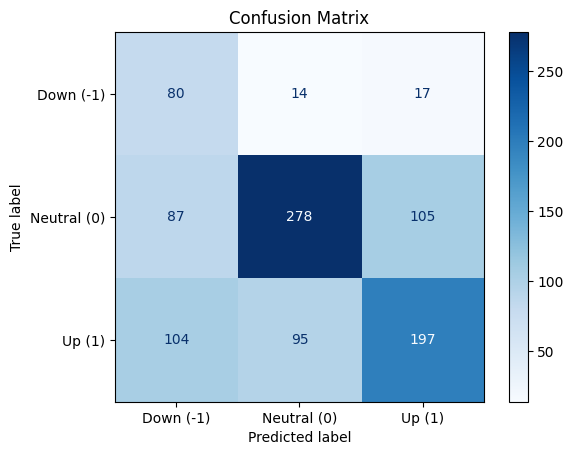

In [76]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)

In [71]:
bt.plot()

/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/aroncheng/backtest-env/lib/python3.9/site-packages/backtesting/_plotting.py:701: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p2011', ...)